# Lab08

Machine-learning for plant modeling

In this lab, we will use R with RStudio to apply statistical and machine learning methods for crop yield predictions using the data from [Jeong et al. (2016)](https://doi.org/10.1371/journal.pone.0156571). Specifically, we will use data from this paper for potato yield from the Northeast Seaboard Region (NESR) ([Resop, Fleisher, Timlin, & Reddy, 2014](https://doi.org/10.2134/agronj2013.0277)). Corn silage data from the same region are also available for homework exercises. Jeong et al. (2016) evaluated multiple linear regression and random forests regression. Here, we will add a DNN method using TensorFlow package for comparison.

Julia also provides comparable tools for machine learning. Here we use [MLJ.jl](https://github.com/alan-turing-institute/MLJ.jl) package for implementing the same models originally written in R.

In [1]:
import Pkg

In [2]:
using Logging
Logging.disable_logging(Logging.Warn)
Logging.disable_logging(Logging.Info)

LogLevel(1)

In [3]:
using MLJ

In [4]:
#Pkg.add("Plots")

In [5]:
using CSV
using DataFrames
using DataFramesMeta: DataFramesMeta, @subset
using Plots

We will also use [Flux.jl](https://github.com/FluxML/Flux.jl) later in the notebook. It turns out that we have to import it early, otherwise our JupyterHub would crash presumably due to memory limitation.

In [6]:
using Flux

### Ex 8.1

We will import and process data used in Jeong et al. (2016) to train and test three regression methods: generalized linear model(GLM), random forests (RF), and deep neural networks (DNN) to predict potato yield from NESR. These data were compiled from multiple sources including county yield statistics, weather data, soil database (SSURGO), and geospatial data.

#### Ex 8.1.1

Import data "L08-potato.csv" into a dataframe.

In [7]:
crop = CSV.read("./L08-potato.csv", DataFrame)

Row,obs_yield,precip,rad,maxt,mint,sat,hyd,clay,bulk,water,lat,long,elev
,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Int64,Float64,Float64,Float64
1,missing,384.39,19.44,25.94,12.48,0.43,753.36,0.04,1.23,1,43.48,-70.72,92.36
2,missing,384.39,19.44,25.94,12.48,0.48,717.67,0.04,1.13,1,43.48,-70.72,92.36
3,missing,384.39,19.44,25.94,12.48,0.41,1018.21,0.04,1.34,1,43.48,-70.72,92.36
4,missing,344.22,19.27,23.72,11.25,0.47,124.82,0.07,1.08,1,44.97,-70.44,471.2
5,missing,344.22,19.27,23.72,11.25,0.43,94.35,0.08,1.13,1,44.97,-70.44,471.2
6,missing,344.22,19.27,23.72,11.25,0.43,72.21,0.08,1.2,1,44.97,-70.44,471.2
7,29.15,338.68,19.92,24.77,13.87,0.43,504.38,0.03,1.29,1,44.17,-70.21,103.48
8,29.15,338.68,19.92,24.77,13.87,0.4,69.36,0.1,1.33,1,44.17,-70.21,103.48
9,29.15,338.68,19.92,24.77,13.87,0.39,71.27,0.07,1.24,1,44.17,-70.21,103.48


#### Ex 8.1.2

Remove observations with missing or 0 values in "obs_yield" column.

In [8]:
crop = @subset(crop, :obs_yield .> 2) |> dropmissing

Row,obs_yield,precip,rad,maxt,mint,sat,hyd,clay,bulk,water,lat,long,elev
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Float64
1,29.15,338.68,19.92,24.77,13.87,0.43,504.38,0.03,1.29,1,44.17,-70.21,103.48
2,29.15,338.68,19.92,24.77,13.87,0.4,69.36,0.1,1.33,1,44.17,-70.21,103.48
3,29.15,338.68,19.92,24.77,13.87,0.39,71.27,0.07,1.24,1,44.17,-70.21,103.48
4,21.14,374.99,19.61,24.8,12.18,0.39,18.84,0.26,1.44,1,44.5,-69.15,105.64
5,21.14,374.99,19.61,24.8,12.18,0.48,66.36,0.07,1.06,1,44.5,-69.15,105.64
6,21.14,374.99,19.61,24.8,12.18,0.48,165.68,0.06,1.01,1,44.5,-69.15,105.64
7,20.94,364.26,19.94,22.19,9.95,0.43,591.93,0.03,1.35,1,45.04,-67.64,80.61
8,20.94,364.26,19.94,22.19,9.95,0.36,390.2,0.03,1.54,1,45.04,-67.64,80.61
9,20.94,364.26,19.94,22.19,9.95,0.4,483.88,0.05,1.43,1,45.04,-67.64,80.61


#### Ex 8.1.3

Randomly select 70% of data for model training and save the rest for model testing.

Here we exclude `water` column since the value looks categorical. We assume continuous values for our regression models.

In [9]:
y, X = unpack(crop, ==(:obs_yield), !=(:water), c -> true);

In [10]:
train, test = partition(eachindex(y), 0.7)

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  722, 723, 724, 725, 726, 727, 728, 729, 730, 731], [732, 733, 734, 735, 736, 737, 738, 739, 740, 741  …  1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044])

For the structure of our dataset, we can choose many different types of machine learning models.

In [11]:
models(matching(X, y))

70-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :deep_properties, :docstring, :fit_data_scitype, :human_name, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :reporting_operations, :reports_feature_importances, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :transform_scitype, :input_scitype, :target_scitype, :output_scitype)}}:
 (name = ARDRegressor, package_name = MLJScikitLearnInterface, ... )
 (name = AdaBoostRegressor, package_name = MLJScikitLearnInterface, ... )
 (name = BaggingRegressor, package_name = MLJScikitLearnInterface, ... )
 (name = BayesianRidgeRegressor, package_name = MLJScikitLearnInterface, ... )
 (name = CatBoostRegressor, package_name = CatBoost, ... )
 (name = ConstantRegress

## Linear Regression

### Ex 8.2

R: Using "lm" package for generalized linear models (GLM), we will build a multiple linear regression model to predict crop yield based on environmental and management data as input.

Julia: We load a linear regression model provided by [MLJLinearModels.jl](https://github.com/JuliaAI/MLJLinearModels.jl) package.

#### Ex 8.2.1

Train GLM to predict crop yield in the training data.

In [12]:
LinearRegressor = @load LinearRegressor pkg = MLJLinearModels

import MLJLinearModels ✔


MLJLinearModels.LinearRegressor

In [13]:
lr = LinearRegressor()

LinearRegressor(
  fit_intercept = true, 
  solver = nothing)

In [14]:
lr_mach = machine(lr, X, y)

untrained Machine; caches model-specific representations of data
  model: LinearRegressor(fit_intercept = true, …)
  args: 
    1:	Source @603 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @851 ⏎ AbstractVector{Continuous}


In [15]:
fit!(lr_mach, rows = train)

trained Machine; caches model-specific representations of data
  model: LinearRegressor(fit_intercept = true, …)
  args: 
    1:	Source @603 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @851 ⏎ AbstractVector{Continuous}


In [16]:
fitted_params(lr_mach)

(coefs = [:precip => 0.009077882738369467, :rad => -2.0554787667548764, :maxt => -0.31398884546224387, :mint => 1.3134130035473655, :sat => -4.045096391957836, :hyd => -0.002346061701486486, :clay => 0.5592332000398752, :bulk => 1.2394266471066193, :lat => 1.1803158479933924, :long => -0.6282659815774531, :elev => 0.0008195231095624988],
 intercept = -46.942554060091176,)

#### Ex 8.2.2

Plot predicted vs. observed yield of training data with a regression line and 1:1 line embedded.

In [17]:
lr_ŷ_train = predict(lr_mach, X[train, :]);

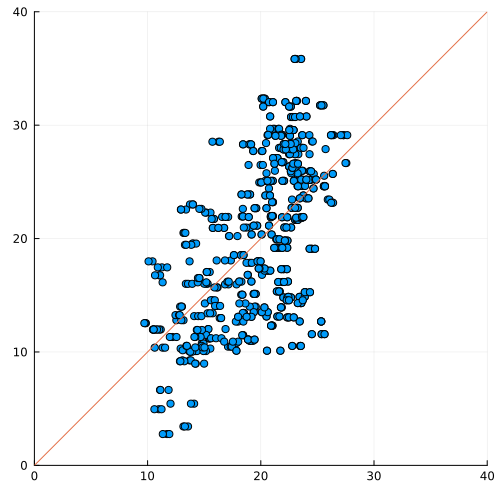

In [18]:
scatter(lr_ŷ_train, y[train]; label = "", xlim = (0, 40), ylim = (0, 40), size = (500, 500))
Plots.abline!(1, 0; label = "")

In [19]:
rmse(lr_ŷ_train, y[train])

5.791956918627695

#### Ex 8.2.3

Predict crop yield in the test data based the GLM model you just trained.

In [20]:
lr_ŷ_test = predict(lr_mach, X[test, :]);

#### Ex 8.2.4

Plot predicted vs. observed yield of test data with a regression line and 1:1 line embedded.

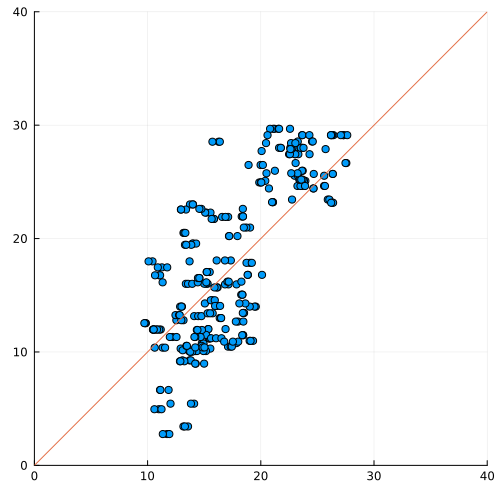

In [21]:
scatter(lr_ŷ_test, y[test]; label = "", xlim = (0, 40), ylim = (0, 40), size = (500, 500))
Plots.abline!(1, 0; label = "")

In [22]:
rmse(lr_ŷ_test, y[test])

4.745386064921416

#### Ex 8.2.5

Discuss and interpret your results.

## Random Forest

### Ex 8.3

R: Using "randomForest" package, we will a random forest regression model to predict crop yield based on environmental and management data as input.

Julia: We load a random forest model provided by [DecisionTree.jl](https://github.com/JuliaAI/DecisionTree.jl) package.

#### Ex 8.3.1

Train a RF model to predict crop yield in the training data.

In [23]:
RandomForestRegressor = @load RandomForestRegressor pkg = DecisionTree

import MLJDecisionTreeInterface ✔


MLJDecisionTreeInterface.RandomForestRegressor

In [24]:
rf = RandomForestRegressor()

RandomForestRegressor(
  max_depth = -1, 
  min_samples_leaf = 1, 
  min_samples_split = 2, 
  min_purity_increase = 0.0, 
  n_subfeatures = -1, 
  n_trees = 100, 
  sampling_fraction = 0.7, 
  feature_importance = :impurity, 
  rng = Random._GLOBAL_RNG())

In [25]:
evaluate(rf, X, y)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:01


PerformanceEvaluation object with these fields:
  model, measure, operation,
  measurement, per_fold, per_observation,
  fitted_params_per_fold, report_per_fold,
  train_test_rows, resampling, repeats
Extract:
┌──────────┬───────────┬─────────────┐
│ measure  │ operation │ measurement │
├──────────┼───────────┼─────────────┤
│ LPLoss(  │ predict   │ 2.67        │
│   p = 2) │           │             │
└──────────┴───────────┴─────────────┘
┌──────────────────────────────────────┬─────────┐
│ per_fold                             │ 1.96*SE │
├──────────────────────────────────────┼─────────┤
│ [4.43, 1.65, 2.16, 3.84, 1.68, 2.26] │ 1.03    │
└──────────────────────────────────────┴─────────┘


In [26]:
rf_mach = machine(rf, X, y)

untrained Machine; caches model-specific representations of data
  model: RandomForestRegressor(max_depth = -1, …)
  args: 
    1:	Source @720 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @148 ⏎ AbstractVector{Continuous}


In [27]:
fit!(rf_mach, rows = train)

trained Machine; caches model-specific representations of data
  model: RandomForestRegressor(max_depth = -1, …)
  args: 
    1:	Source @720 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @148 ⏎ AbstractVector{Continuous}


In [28]:
rf_mach.model

RandomForestRegressor(
  max_depth = -1, 
  min_samples_leaf = 1, 
  min_samples_split = 2, 
  min_purity_increase = 0.0, 
  n_subfeatures = -1, 
  n_trees = 100, 
  sampling_fraction = 0.7, 
  feature_importance = :impurity, 
  rng = Random._GLOBAL_RNG())

In [29]:
fitted_params(rf_mach)

(forest = Ensemble of Decision Trees
Trees:      100
Avg Leaves: 212.79
Avg Depth:  17.63,)

We can also visualize a part of the one of the decision "trees" composing the "forest". Note that decisions are made by comparing "Features" with some fitted values.

In [30]:
import DecisionTree
DecisionTree.print_tree(fitted_params(rf_mach).forest.trees[1], 5)

Feature 10 < -78.24 ?
├─ Feature 2 < 20.58 ?
    ├─ Feature 9 < 40.78 ?
        ├─ Feature 3 < 25.89 ?
            ├─ 23.21 : 5/5
            └─ Feature 7 < 0.255 ?
                ├─ 25.2 : 4/4
                └─ 25.09 : 3/3
        └─ Feature 4 < 13.6 ?
            ├─ Feature 8 < 1.46 ?
                ├─ 29.68 : 1/1
                └─ 
            └─ 26.66 : 2/2
    └─ Feature 4 < 13.23 ?
        ├─ Feature 1 < 345.9 ?
            ├─ Feature 11 < 193.5 ?
                ├─ 19.82 : 4/4
                └─ 
            └─ Feature 4 < 12.33 ?
                ├─ 
                └─ 
        └─ Feature 8 < 1.655 ?
            ├─ Feature 1 < 303.2 ?
                ├─ 
                └─ 
            └─ 16.14 : 3/3
└─ Feature 9 < 39.76 ?
    ├─ Feature 10 < -76.12 ?
        ├─ Feature 4 < 15.57 ?
            ├─ Feature 7 < 0.19 ?
                ├─ 
                └─ 
            └─ Feature 10 < -76.84 ?
                ├─ 
                └─ 8.97 : 2/2
        └─ Feature 11 < 5.445 ?
   

"Features" are the variables we supplied for training the model.

In [31]:
report(rf_mach)

(features = [:precip, :rad, :maxt, :mint, :sat, :hyd, :clay, :bulk, :lat, :long, :elev],)

#### Ex 8.3.2

Plot predicted vs. observed yield of training data with a regression line and 1:1 line embedded.

In [32]:
rf_ŷ_train = predict(rf_mach, X[train, :]);

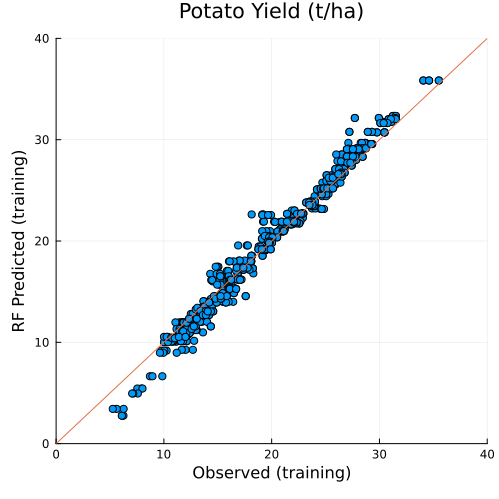

In [33]:
scatter(rf_ŷ_train, y[train]; title="Potato Yield (t/ha)", label = "", xlim = (0, 40), ylim = (0, 40), size = (500, 500))
Plots.abline!(1, 0; label = "")
Plots.xaxis!("Observed (training)")
Plots.yaxis!("RF Predicted (training)")

In [34]:
rmse(rf_ŷ_train, y[train])

1.091750822749408

#### Ex 8.3.3

Predict crop yield in the test data based the RF model you just trained.

In [35]:
rf_ŷ_test = predict(rf_mach, X[test, :]);

#### Ex 8.3.4

Plot predicted vs. observed yield of test data with a regression line and 1:1 line embedded.

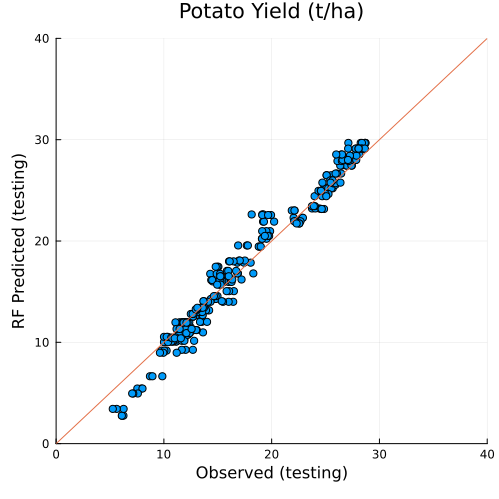

In [36]:
scatter(rf_ŷ_test, y[test]; title="Potato Yield (t/ha)",label = "", xlim = (0, 40), ylim = (0, 40), size = (500, 500))
Plots.abline!(1, 0; label = "")
Plots.xaxis!("Observed (testing)")
Plots.yaxis!("RF Predicted (testing)")

In [37]:
rmse(rf_ŷ_test, y[test])

1.278888606122132

#### Ex 8.3.5

Discuss and interpret your results.

## Neural Network

### Ex 8.4

R: Using the data prepared from Ex. 8.1 with "keras" and "tensorflow" packages, we will build a DNN regression model to predict crop yield based on environmental and management data as input.

Julia: We load a neural network regression model provided by [MLJFlux.jl](https://github.com/FluxML/MLJFlux.jl) package, which is built on a popular deep learning package [Flux.jl](https://github.com/FluxML/Flux.jl).

#### Ex 8.4.1

Train a DNN model to predict crop yield in the training data.

In [38]:
using Flux

For neural network, data for different variables are put into the same scale.
That is, driving variables should be normalized, or standardized, to scale their effects.

In [39]:
Standardizer = @load Standardizer pkg = MLJModels

import MLJModels ✔


MLJModels.Standardizer

In [40]:
NeuralNetworkRegressor = @load NeuralNetworkRegressor pkg = MLJFlux

import MLJFlux ✔


MLJFlux.NeuralNetworkRegressor

Create a DNN model with a few layers of neural network including "hidden" layers. 
The name "hidden" here just means not directly connected to the inputs or outputs.
Two hidden, non-linear, dense layers are added with the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) function.
Another layer of linear dense single-output is then added.
Define a DNN model to be built and compiled using a default optimizer.

In [41]:
builder = MLJFlux.@builder Chain(Dense(n_in, 64, relu), Dense(64, 64, relu), Dense(64, n_out))
nn = NeuralNetworkRegressor(; builder, epochs = 200)

NeuralNetworkRegressor(
  builder = GenericBuilder(
        apply = var"#5#6"()), 
  optimiser = Adam(0.001, (0.9, 0.999), 1.0e-8), 
  loss = Flux.Losses.mse, 
  epochs = 200, 
  batch_size = 1, 
  lambda = 0.0, 
  alpha = 0.0, 
  rng = Random.TaskLocalRNG(), 
  optimiser_changes_trigger_retraining = false, 
  acceleration = CPU1{Nothing}(nothing))

The entire model pipeline starts with a standardizer to normalize input data which are fed into the actual neural network model. The output from the model is also transformed via another standardizer to better scale with an actual range of output values.

In [42]:
pipe = Standardizer |> TransformedTargetModel(nn, transformer = Standardizer)

DeterministicPipeline(
  standardizer = Standardizer(
        features = Symbol[], 
        ignore = false, 
        ordered_factor = false, 
        count = false), 
  transformed_target_model_deterministic = TransformedTargetModelDeterministic(
        model = NeuralNetworkRegressor(builder = GenericBuilder(apply = #5), …), 
        transformer = Standardizer(features = Symbol[], …), 
        inverse = nothing, 
        cache = true), 
  cache = true)

In [43]:
nn_mach = machine(pipe, X, y)

untrained Machine; does not cache data
  model: DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …)
  args: 
    1:	Source @845 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @595 ⏎ AbstractVector{Continuous}


In [44]:
fit!(nn_mach, rows = train)

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(11 => 64, relu)  # 768 parameters
│   summary(x) = "11×1 Matrix{Float64}"
└ @ Flux /opt/julia/packages/Flux/HBF2N/src/layers/stateless.jl:60
Optimising neural net: 100%[=========================] Time: 0:00:21


trained Machine; does not cache data
  model: DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …)
  args: 
    1:	Source @845 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @595 ⏎ AbstractVector{Continuous}


Plot the history of training. 'epochs' is like iterations of training.

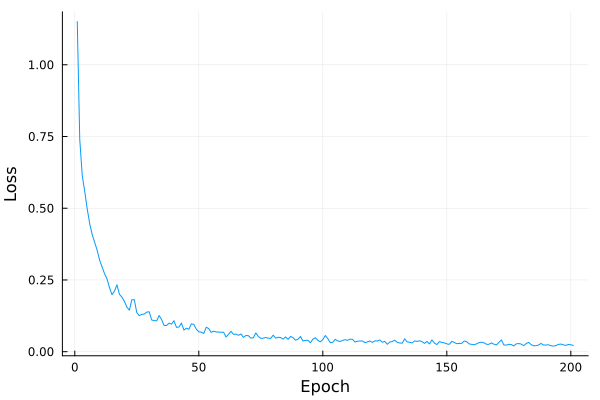

In [45]:
let L = report(nn_mach).transformed_target_model_deterministic.model.training_losses
    plot(1:length(L), L, label = "", xlab = "Epoch", ylab = "Loss")
end

#### EX 8.4.2

Plot predicted vs. observed yield of training data with a regression line and 1:1 line embedded.

In [46]:
nn_ŷ_train = predict(nn_mach, X[train, :]);

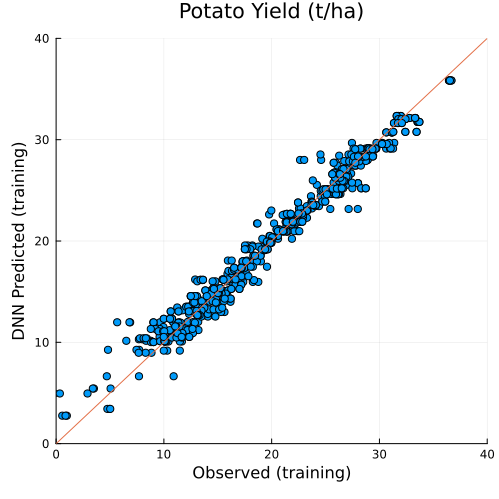

In [47]:
scatter(nn_ŷ_train, y[train]; title="Potato Yield (t/ha)", label = "", xlim = (0, 40), ylim = (0, 40), size = (500, 500))
Plots.abline!(1, 0; label = "")
Plots.xaxis!("Observed (training)")
Plots.yaxis!("DNN Predicted (training)")

In [48]:
rmse(nn_ŷ_train, y[train])

1.2680762704786233

#### Ex 8.4.3

Predict crop yield in the test data based the DNN model you just trained.

In [49]:
nn_ŷ_test = predict(nn_mach, X[test, :]);

#### Ex 8.4.4

Plot predicted vs. observed yield of test data with a regression line and 1:1 line embedded.

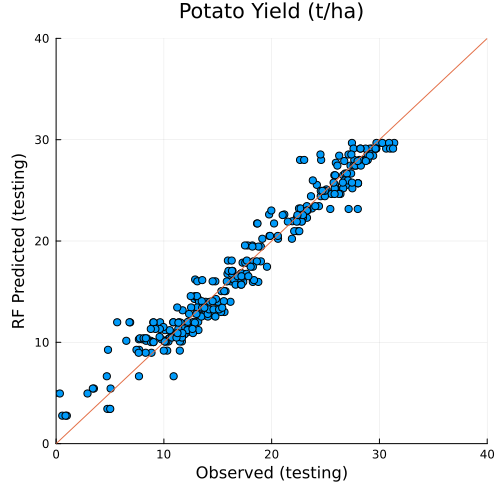

In [50]:
scatter(nn_ŷ_test, y[test]; title="Potato Yield (t/ha)", label = "", xlim = (0, 40), ylim = (0, 40), size = (500, 500))
Plots.abline!(1, 0; label = "")
Plots.xaxis!("Observed (testing)")
Plots.yaxis!("RF Predicted (testing)")

In [51]:
rmse(nn_ŷ_test, y[test])

1.6059645922199255

#### Ex 8.4.5

Discuss and interpret your results.

### Ex 8.5

R: We will do a set of model performance evaluations using "hydroGOF" package.

Julia: We instead use internal metric functions from Cropbox.

In [52]:
import Cropbox

WebIO._IJuliaInit()

In [53]:
calculate(O, a...) = begin
    f(n, E) = DataFrame(
        name = n,
        rmse = Cropbox.metricfunc(:rmse)(E, O),
        ef = Cropbox.metricfunc(:ef)(E, O),
        dr = Cropbox.metricfunc(:dr)(E, O),
    )
    vcat([f(n, E) for (n, E) in a]...)
end 

calculate (generic function with 1 method)

#### Ex 8.5.1

Evaluate and discuss the performance of each modeling method for training data. Compare RMSE, EF (shown as NSE), and Willmott’s d between models. See Jeong et al. (2016) for their definitions.

In [54]:
stats_train = calculate(y[train],
    "train.lr" => lr_ŷ_train,
    "train.rf" => rf_ŷ_train,
    "train.nn" => nn_ŷ_train,
)

Row,name,rmse,ef,dr
,String,Float64,Float64,Float64
1,train.lr,5.79196,0.320213,0.60561
2,train.rf,1.09175,0.975847,0.933586
3,train.nn,1.26808,0.967415,0.925022


#### Ex 8.5.2

Evaluate and discuss the performance of each modeling method for test data. Compare RMSE, EF (shown as NSE), and Willmott’s d between models.

In [55]:
stats_test = calculate(y[test],
    "test.lr" => lr_ŷ_test,
    "test.rf" => rf_ŷ_test,
    "test.nn" => nn_ŷ_test,
)

Row,name,rmse,ef,dr
,String,Float64,Float64,Float64
1,test.lr,4.74539,0.564776,0.685306
2,test.rf,1.27889,0.968389,0.923117
3,test.nn,1.60596,0.950153,0.905168


#### Ex 8.5.3

Export the results of training, testing, and performance evaluations to separate .csv files.

In [56]:
stats = [stats_train; stats_test]

Row,name,rmse,ef,dr
,String,Float64,Float64,Float64
1,train.lr,5.79196,0.320213,0.60561
2,train.rf,1.09175,0.975847,0.933586
3,train.nn,1.26808,0.967415,0.925022
4,test.lr,4.74539,0.564776,0.685306
5,test.rf,1.27889,0.968389,0.923117
6,test.nn,1.60596,0.950153,0.905168


In [57]:
CSV.write("stats.csv", stats)

"stats.csv"

#### Ex 8.5.4

Discuss and interpret your results.

### Ex 8.6

Follow the same modeling process to create predictions for corn silage data (L08-silage.csv), evaluate the performance of models, and discuss the results.

In [58]:
silage = CSV.read("./L08-silage.csv", DataFrame)

Row,obs_yield,precip,rad,maxt,mint,sat,hyd,clay,bulk,water,lat,long,elev
,Float64?,Float64,Float64,Float64,Float64,Float64?,Float64?,Float64?,Float64?,Int64,Float64,Float64,Float64
1,31.7,377.2,19.42,25.98,12.53,0.43,753.36,0.04,1.23,1,43.48,-70.72,92.36
2,31.7,377.2,19.42,25.98,12.53,0.48,717.67,0.04,1.13,1,43.48,-70.72,92.36
3,31.7,377.2,19.42,25.98,12.53,0.41,1018.21,0.04,1.34,1,43.48,-70.72,92.36
4,39.9,339.78,19.23,23.8,11.32,0.47,124.82,0.07,1.08,1,44.97,-70.44,471.2
5,39.9,339.78,19.23,23.8,11.32,0.43,94.35,0.08,1.13,1,44.97,-70.44,471.2
6,39.9,339.78,19.23,23.8,11.32,0.43,72.21,0.08,1.2,1,44.97,-70.44,471.2
7,37.88,330.57,19.91,24.84,13.94,0.43,504.38,0.03,1.29,1,44.17,-70.21,103.48
8,37.88,330.57,19.91,24.84,13.94,0.4,69.36,0.1,1.33,1,44.17,-70.21,103.48
9,37.88,330.57,19.91,24.84,13.94,0.39,71.27,0.07,1.24,1,44.17,-70.21,103.48
